# Lab 2, exercise 5

### Ganna Fagerberg

In [ ]:
# Gaussian process regression for the bike share data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from math import exp
import numpy as geek
from matplotlib import pyplot as plt 

In [2]:
# Import the dataset
url ="https://github.com/mattiasvillani/MLcourse/raw/main/Data/BikeShareData/hour.csv"
df = pd.read_csv(url)

In [3]:
# Format the "cnt" and "hour" variables
df['logrides'] = np.log(df['cnt'])
df['hour']=(df['hr'])/23

In [4]:
# Extract the training set (February 2011)
df.set_index('dteday',inplace=True)
bikesTrain = df['2011-02-01':'2011-02-28']
bikesTrain.shape 

(649, 18)

In [5]:
# Extract the response and predictor variables from the training set
y=bikesTrain['logrides']
y = y[:, np.newaxis]
#y.shape #(649, 1)
x=bikesTrain['hour']
x = x[:, np.newaxis]
#x.shape #(649,)

<ipython-input-5-06658e5a8667>:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
<ipython-input-5-06658e5a8667>:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


In [6]:
# Create test data
x_test=np.linspace(start=0, stop=1, num=1000)
x_test = x_test[:, np.newaxis]
#x_test.shape #(1000,1)

In [7]:
x

array([[0.        ],
       [0.04347826],
       [0.08695652],
       [0.13043478],
       [0.2173913 ],
       [0.26086957],
       [0.30434783],
       [0.34782609],
       [0.39130435],
       [0.43478261],
       [0.47826087],
       [0.52173913],
       [0.56521739],
       [0.60869565],
       [0.65217391],
       [0.69565217],
       [0.73913043],
       [0.7826087 ],
       [0.82608696],
       [0.86956522],
       [0.91304348],
       [0.95652174],
       [1.        ],
       [0.        ],
       [0.04347826],
       [0.08695652],
       [0.13043478],
       [0.17391304],
       [0.2173913 ],
       [0.26086957],
       [0.30434783],
       [0.34782609],
       [0.39130435],
       [0.43478261],
       [0.47826087],
       [0.52173913],
       [0.56521739],
       [0.60869565],
       [0.65217391],
       [0.69565217],
       [0.73913043],
       [0.7826087 ],
       [0.82608696],
       [0.86956522],
       [0.91304348],
       [0.95652174],
       [1.        ],
       [0.   

In [8]:
# Fit polynomial of order 3 and extract the residual variance
from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
polynomial_features= PolynomialFeatures(degree=3)
#x_poly = polynomial_features.fit_transform(x)
x_poly = polynomial_features.fit_transform(x)
model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)
res_sq=sum((y-y_poly_pred)**2)
res_sq
res_var=res_sq/645
res_var #0.80371967

array([0.80371967])

In [9]:
# Fit the polynomial model manually

In [10]:
# Add the noise term to the training data
m, n = x.shape
X = np.hstack((np.ones((m, 1)), x))
# Add polynomial terms to X (order=3)
X = np.hstack((
    X,
    (X[:, 1] ** 2).reshape((m, 1)),
    (X[:, 1] ** 3).reshape((m, 1))
))

In [11]:
# Compute the beta coefficients
X_trs=np.transpose(X) # transposed X matrix
betaHat=np.linalg.inv(X_trs@X)@X_trs@y
betaHat
# Compute the predictions
yFit = X@betaHat

In [12]:
# Compute the residual variance
res_sq2=sum((y-yFit)**2)
res_sq2
res_var2=res_sq2/645
res_var2 #0.80371967

array([0.80371967])

In [14]:
# Fit the GP regression

In [15]:
# Define function to copmpute covariance matrices with the exponential kernel
def cov(data, scale, length, test=None):
    if test is None:
        dat_mat=np.repeat(a=data, repeats=len(data), axis = 1)
        dat_tr=np.transpose(dat_mat)
        cov = (scale**2)*np.exp(-(1/2)*(dat_mat - dat_tr)**2/length**2)
    else:
        dat_mat=np.transpose(np.repeat(a=x, repeats=len(test), axis = 1))
        x_test=np.repeat(a=test, repeats=len(data), axis = 1)
        cov = (scale**2)*np.exp(-(1/2)*(x_test-dat_mat )**2/length**2)
    return cov

In [16]:
# Define function to compute the GP posterior
def sample_posterior(x_train, y_train, x_test, size, scale, length, noise):
    
    # Compute Sigma
    I = geek.identity(649, dtype = float)
    Sigma=np.linalg.inv(cov(x_train, scale,length)+noise*I) # (649, 649)
    
    # Compute the posterior mean
    mean_vect = cov(x_train, scale, length, x_test) @ Sigma @ y_train # (649,)
   
    # Compute the posterior covariance matrix
    cov_matrix = cov(x_test, scale, length)- cov(x_train, scale, length, x_test) @ Sigma @ np.transpose(cov(x_train, scale, length, x_test))
    # (1000,1000)
    
    # Compute the posterior predictions
    yPreds=np.random.multivariate_normal(mean_vect.flatten(), cov_matrix, size=size).T
    # (1000, 1000)
    
    return yPreds,  mean_vect, cov_matrix 
    

In [17]:
# Compute and extract the posterior mean, covariance matrix and predictions
pred=sample_posterior(x, y, x_test, size=6, scale=5, length=0.1, noise=res_var)
y_mean=pred[1]
y_cov=pred[2]
y_pred=pred[0]

In [19]:
#  Compute the 95% confidence bounds for the mean vector
error = 1.96 * np.sqrt(y_cov.diagonal())
q1=y_mean.flatten() - error
q2=y_mean.flatten() + error

<function matplotlib.pyplot.show(close=None, block=None)>

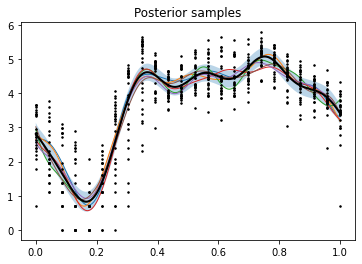

In [20]:
# Plot the GP fit to the data
# Plot samples from the posterior
plt.plot(x_test, y_pred, linewidth=1)
# Plot posterior mean and 95% CI
plt.plot(x_test, y_mean, linewidth=2, color='black')
plt.fill_between(x_test[:, 0],q1, q2, alpha=0.3)
plt.plot(x, y, '.', color='black',markersize=3)
plt.title('Posterior samples')
plt.show
